## Notebook Description
This notebook contains the code for finalizing the model <br>
**Date of Last Update**: November 29th 2020

---

**INPUTS**: Data/train, Data/val, Data/validation <br>
directory containing image files sorted by class and train test val

**OUTPUTS**: Model <br>

---

### Previous Steps
- Parameter Selection

### Next Steps
- Deployment

---

## Import Packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.optim import lr_scheduler
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook

import numpy as np
import pandas as pd

import time 
import os
import copy
import math

import itertools

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import register_cmap
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
from google.colab import files

## Import Pretrained ResNet18

In [ ]:
resnet18 = models.resnet18(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
torch.manual_seed(42)

## Create Ploting Function

In [ ]:
def get_plots(df):
  """creates plots of train vs val loss and train vs val accuracy
  INPUTS df, dataframe of training stats by epoch
  RETURNS None"""

  # plot for loss
  fig = go.Figure(layout=go.Layout(
        title="Loss by Training Epoch",
        xaxis = dict(
            title = "Training Epoch"
        ),
        yaxis=dict(
            title = "Loss"
        )
    ))
  fig.add_trace(go.Scatter(x=df["epoch"], y=df["training_loss"],
                    mode='lines',
                    name='training',
                    line_color = '#1B848E'))
  fig.add_trace(go.Scatter(x=df["epoch"], y=df["val_loss"],
                    mode='lines',
                    name='validation',
                    line_color = '#33B8B5'))

  fig.show()


  # plot for accuracy
  fig = go.Figure(layout=go.Layout(
        title="Accuracy by Training Epoch",
        xaxis = dict(
            title = "Training Epoch"
        ),
        yaxis=dict(
            title = "Accuracy"
        )
  ))
  fig.add_trace(go.Scatter(x=df["epoch"], y=df["training_acc"],
                    mode='lines',
                    name='training',
                    line_color = '#1B848E'))
  fig.add_trace(go.Scatter(x=df["epoch"], y=df["val_acc"],
                    mode='lines',
                    name='validation',
                    line_color = '#33B8B5'))

  fig.show()

  return

## Define Function to Freeze Blocks

In [ ]:
def block_freeze (model, child_stop_num):
    """performs layer freezing
    INPUTS: model, child_stop_num - layer at which the layers will not be frozen (exclusive)
    RETURNS: updated model"""
    
    count = 0
    for child in model.children():
        if count < child_stop_num:
            for p in child.parameters():
                p.requires_grad = False
        count += 1
    
    return model

## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# base path to data location
###
base_path = 'gdrive/MyDrive/Data'

# create data transforms 
# normalize and augment(where applicable)
###
data_transforms = {
    'train' : transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224), 
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([ 
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
                  }

# create image datasets 
###
image_datasets ={ x : datasets.ImageFolder(os.path.join(base_path, x), 
                                          data_transforms[x])
                for x in ['train', 'val']}

# create dataloaders
###
dataloaders = { x : torch.utils.data.DataLoader(image_datasets[x], 
                                                batch_size = 2, 
                                                shuffle = True, 
                                                num_workers = 4)
              for x in ['train', 'val']}

datasizes = { x : len(image_datasets[x]) for x in ['train', 'val']}

#create class labels
###
class_labels = image_datasets['train'].classes

In [ ]:
## define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Defining Confusion Matrix

In [ ]:
def cfm_matrix(nb_classes, model, dataloaders):
  """obtains confusion matrix and class accuracies
  INPUTS - nb_classes, model, dataloaders
  RETURNS - confusion_matrix, 
          - avg_class_acc = average accuracy by class
          - running = list of the class accuracies"""
  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      for t, p in zip(classes.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

  # get the accuracy by class
  class_acc = confusion_matrix.diag()/confusion_matrix.sum(1)

  # manipulate for the average class accuracy
  running = []
  if (math.isnan(class_acc[0].item())==False):
    zero = class_acc[0].item()
    running.append(zero)
  if (math.isnan(class_acc[1].item())==False):
    one = class_acc[1].item()
    running.append(one)
  if (math.isnan(class_acc[2].item())==False):
    two = class_acc[2].item()
    running.append(two)
  if (math.isnan(class_acc[3].item())==False):
    three = class_acc[3].item()
    running.append(three)
  if (math.isnan(class_acc[4].item())==False):
    four = class_acc[4].item()
    running.append(four)

  sum = 0
  for run in running:
    sum += run
  class_avg_acc = sum/len(running) 

  return confusion_matrix, class_avg_acc, running

In [ ]:
def plot_confusion_matrix(cfm, class_labels):
  for i in range(len(cfm)):
    if cfm[i].sum() == 0:
      to_drop = i

  if to_drop == 0:
    cf_matrix = [[cfm[1][1].item(), cfm[1][2].item(), cfm[1][3].item(), cfm[1][4].item()],
                 [cfm[2][1].item(), cfm[2][2].item(), cfm[2][3].item(), cfm[2][4].item()],
                 [cfm[3][1].item(), cfm[3][2].item(), cfm[3][3].item(), cfm[3][4].item()],
                 [cfm[4][1].item(), cfm[4][2].item(), cfm[4][3].item(), cfm[4][4].item()]]
  elif to_drop == 4:
    cf_matrix = [[cfm[0][0].item(), cfm[0][1].item(), cfm[0][2].item(), cfm[0][3].item()],
                 [cfm[1][0].item(), cfm[1][1].item(), cfm[1][2].item(), cfm[1][3].item()],
                 [cfm[2][0].item(), cfm[2][1].item(), cfm[2][2].item(), cfm[2][3].item()],
                 [cfm[3][0].item(), cfm[3][1].item(), cfm[3][2].item(), cfm[3][3].item()]]
  else:
    print("error please try again")
    return 

  plt.figure(figsize=(10, 8))

  pos = [0.0,1.0]
  colors = ["#33B8B5", "#E1896D"]
  cmap2 = LinearSegmentedColormap.from_list("", list(zip(pos, colors)))
  register_cmap("my_cmap", cmap2)
  palette= sns.color_palette("my_cmap",n_colors=50)

  x_axis_labels = class_labels # labels for x-axis
  y_axis_labels = class_labels # labels for y-axis

  cf_matrix = np.array(cf_matrix)
  ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
              fmt='.2%', cmap = cmap2, xticklabels=x_axis_labels, 
              yticklabels=y_axis_labels)
  plt.yticks(rotation=0)
  plt.title("Confusion Matrix")
  plt.savefig("ConfusionMatrix.png")
  files.download("ConfusionMatrix.png") 
  
  plt.show()

  return 

In [ ]:
plot_confusion_matrix(cfm, class_labels)

NameError: ignored

In [ ]:
print(class_labels)

['alligator_cracking', 'good_condition', 'longitudinal_cracking', 'potholes']


## Define Training Function 
- add in confusion matrix information

In [ ]:
def train(model, criterion, optimizer, num_epochs, scheduler):

  #initalize tracking
  best_acc = 0.0
  best_avg_acc = 0.0
  train_loss = {}
  val_loss = {}
  train_acc = {}
  val_acc = {}


  #create training loop
  for epoch in range(num_epochs):
    print(epoch+1, ' / ', num_epochs)
    print('--' * 15)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      #initalize epoch tracking
      running_loss = 0.0
      no_correct = 0

      #loop for data
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        #zero the gradients 
        optimizer.zero_grad()
        
        #forward (only for train phase)
        with torch.set_grad_enabled(phase == "train"):
          outputs = model(inputs)
          _, preds = torch.max(outputs,1)
          loss = criterion(outputs, labels)
                    
          #backward (only for train)
          if phase == 'train' : 
            loss.backward()
            optimizer.step()
                
        #update tracking
        running_loss += loss.item() * inputs.size(0)
        no_correct += torch.sum(preds == labels.data)
            
      #step for scheduler 
      if phase == 'train':
        scheduler.step()
            
      #get epoch stats
      epoch_loss = running_loss / datasizes[phase]
      epoch_acc = no_correct.double() / datasizes[phase]
            
      if phase == 'train':
        train_loss[epoch] = epoch_loss
        train_acc[epoch] = epoch_acc.item()
      else:
        val_loss[epoch] = epoch_loss
        val_acc[epoch] = epoch_acc.item()
        _, epoch_avg_acc, _ = cfm_matrix(5, model, dataloaders)
        if epoch_acc > best_acc:
          best_acc = epoch_acc
          #deep copy model to store
          best_model = copy.deepcopy(model.state_dict())
          model_epoch = epoch
          best_acc_corr_avg = epoch_avg_acc
        if epoch_avg_acc > best_avg_acc:
          best_avg_acc = epoch_avg_acc
          model_avg_epoch = epoch
          best_avg_corr_acc = epoch_acc

      print(phase, " Loss: ", epoch_loss, " Accuracy: ", epoch_acc)
                        
  print(model_epoch)
  return train_loss, val_loss, train_acc, val_acc, best_acc, best_avg_acc, best_acc_corr_avg, best_avg_corr_acc

In [ ]:
criterion = nn.CrossEntropyLoss()
no_of_epochs = 20
learning_rate = 0.04
step_size = 8
gamma = 0.1
batch_size = 2

#reset model
resnet18 = models.resnet18(pretrained = True)
original_class_len = resnet18.fc.in_features
resnet18.fc = nn.Linear(original_class_len, len(class_labels))
model = block_freeze(resnet18, 7)
model.to(device)

#initalize optimizer, scheduler and dataloader
optimizer = optim.Adam(filter(lambda p:p.requires_grad, 
                                    model.parameters()), 
                            lr = learning_rate)
  
new_lr_scheduler = lr_scheduler.StepLR(optimizer, 
                                         step_size=step_size, 
                                         gamma = gamma)

dataloaders = { x : torch.utils.data.DataLoader(image_datasets[x], 
                                                      batch_size = batch_size, 
                                                      shuffle = True, 
                                                      num_workers = 4)
                    for x in ['train', 'val']}

train_loss, val_loss, train_acc, val_acc, best_acc, best_avg_acc, best_acc_corr_avg, best_avg_corr_acc = train(model, 
                                                          criterion, 
                                                          optimizer, 
                                                          no_of_epochs, 
                                                          new_lr_scheduler)

df = pd.DataFrame.from_dict(train_loss, orient='index')
df1 = pd.DataFrame.from_dict(val_loss, orient='index')
df2 = pd.DataFrame.from_dict(train_acc, orient='index')
df3 = pd.DataFrame.from_dict(val_acc, orient='index')
df = df.merge(df1, right_index=True, left_index=True)
df.rename(columns = {'0_x' : "training_loss", "0_y" : "val_loss"}, inplace=True)
df = df.merge(df2, right_index=True, left_index=True)
df = df.merge(df3, right_index=True, left_index=True)
df.rename(columns = {'0_x' : "training_acc", "0_y" : "val_acc"}, inplace=True)
df.loc[:,"epoch"] = df.index
        
get_plots(df)





1  /  20
------------------------------
train  Loss:  3.921508176276024  Accuracy:  tensor(0.2681, dtype=torch.float64)
val  Loss:  3.246238611891108  Accuracy:  tensor(0.4068, dtype=torch.float64)
2  /  20
------------------------------
train  Loss:  1.3324026361424872  Accuracy:  tensor(0.3957, dtype=torch.float64)
val  Loss:  2.04666448094077  Accuracy:  tensor(0.4746, dtype=torch.float64)
3  /  20
------------------------------
train  Loss:  1.2910427235542459  Accuracy:  tensor(0.4298, dtype=torch.float64)
val  Loss:  0.9467850741693529  Accuracy:  tensor(0.6441, dtype=torch.float64)
4  /  20
------------------------------
train  Loss:  1.1061653307143677  Accuracy:  tensor(0.5021, dtype=torch.float64)
val  Loss:  1.037247894473879  Accuracy:  tensor(0.5254, dtype=torch.float64)
5  /  20
------------------------------
train  Loss:  1.0966319687823032  Accuracy:  tensor(0.5660, dtype=torch.float64)
val  Loss:  0.6015925950418084  Accuracy:  tensor(0.8136, dtype=torch.float64)
6  / 

In [ ]:
print(best_avg_acc)
print(best_acc)

0.8995192348957062
tensor(0.8983, dtype=torch.float64)


In [ ]:
print(best_acc_corr_avg)
print(best_avg_corr_acc)

0.8995192348957062
tensor(0.8983, dtype=torch.float64)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

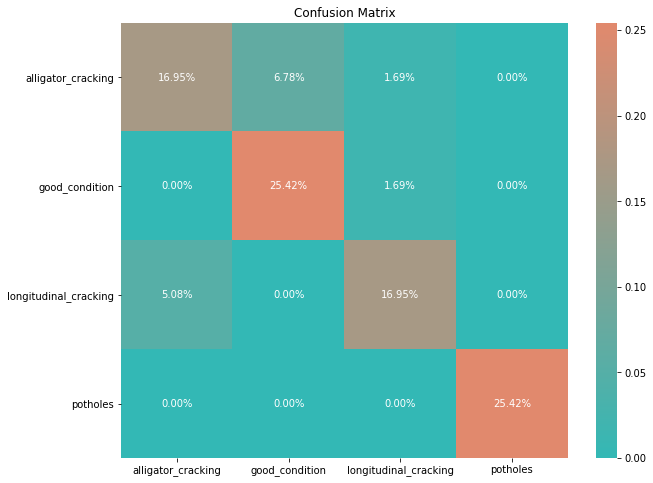

In [ ]:
confusion_matrix, class_avg_acc, running = cfm_matrix(5, model, dataloaders)
plot_confusion_matrix(confusion_matrix, class_labels)

In [ ]:
print(class_avg_acc)


0.8641025722026825


In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
PATH = "gdrive/MyDrive/model20.pt"
torch.save(model, PATH)

In [ ]:
PATH = "gdrive/MyDrive/statedict20"

# Save
torch.save(model.state_dict(), PATH)
